In [146]:
import pandas as pd
import matplotlib.pyplot as plt
from source import data_import
from source.calculate_mean_psd import calculate_mean_psd
from source.constants import CHANNELS, FREQUENCY_RANGES

print(f"loaded channel names: {CHANNELS}")

loaded channel names: ['F4-C4', 'F3-C3', 'FT9-FT10', 'FZ-CZ', 'F7-T7', 'FP2-F4', 'T8-P8-1', 'T8-P8-0', 'FP1-F3', 'CZ-PZ']


In [147]:
# load data
df_pp = data_import.load_pyarrow(file_name="preprocessed_seg")
df_pp.shape

/Users/anabroggini/Documents/bootcamp/ai2/source/../data/preprocessed_seg.arrow was loaded.


(2995200, 16)

In [148]:
df_pp.head()

channel,F4-C4,F3-C3,FT9-FT10,FZ-CZ,F7-T7,FP2-F4,T8-P8-1,T8-P8-0,FP1-F3,CZ-PZ,is_seizure,before_seizure,epoch,segment_id,seizure_start,seizure_id
0 days 00:30:00,16.878726,20.334213,-3.322584,17.941953,18.739373,33.092935,12.625819,12.625819,44.788430,2.790970,False,False,0,0,False,0
0 days 00:30:00.003906250,22.891349,24.865283,-8.175141,23.784967,26.448730,40.639022,11.874291,11.874291,59.506243,4.538652,False,False,0,0,False,0
0 days 00:30:00.007812500,22.162881,25.360125,-8.902114,25.615925,27.023819,40.074853,5.285063,5.285063,60.136641,5.292160,False,False,0,0,False,0
0 days 00:30:00.011718750,29.573426,33.953147,-14.930178,33.038895,32.700204,52.956037,8.308854,8.308854,79.842157,8.558853,False,False,0,0,False,0
0 days 00:30:00.015625,21.292400,18.163275,-11.955401,21.366748,20.938086,35.328903,-1.132117,-1.132117,60.607725,6.096930,False,False,0,0,False,0


## Feature Extraction

In [149]:
# ignore for aggregation
ignore_col = ['is_seizure']
ignore_col = []

In [151]:
### aggregate Functions for mean psd:
delta = lambda x: calculate_mean_psd(x, frequency_ranges={'Delta' : FREQUENCY_RANGES['Delta']})[x.name]['Delta']
theta = lambda x: calculate_mean_psd(x, frequency_ranges={'Theta' : FREQUENCY_RANGES['Theta']})[x.name]['Theta']
gamma = lambda x: calculate_mean_psd(x, frequency_ranges={'Gamma': FREQUENCY_RANGES['Gamma']})[x.name]['Gamma']

delta_agg = pd.NamedAgg(column='delta', aggfunc=delta)
theta_agg = pd.NamedAgg(column='theta', aggfunc=theta)
gamma_agg = pd.NamedAgg(column='gamma', aggfunc=gamma)

In [152]:
df_features = df_pp.groupby(['epoch', 'segment_id', "is_seizure"]).agg(
    {C:[
        'mean', 
        'std',
        'var',
        delta_agg,
        theta_agg,
        gamma_agg
        ] for C in CHANNELS} | 
    {ic: ['first'] for ic in ignore_col}) # just taking first element for target column
df_features.head()

channel                         F4-C4                                     \
                                 mean        std         var       delta   
epoch segment_id is_seizure                                                
0     0          False       1.677760  19.215291  369.227396   39.509423   
      1          False      -0.391839  19.292719  372.208995   57.166882   
      2          False       1.356797  26.026211  677.363658  112.603482   
      3          False      -1.657887  26.999490  728.972443  148.551723   
      4          False       0.776272  23.273241  541.643731   77.372989   

channel                                              F3-C3             \
                                 theta     gamma      mean        std   
epoch segment_id is_seizure                                             
0     0          False       15.649456  1.143016  1.053339  21.315638   
      1          False       13.481116  1.218430  0.811962  25.477037   
      2          False       22.111449  0.943441  1.282874  27.729263   
      3          False       15.161321  1.178056 -2.174102  29.614908   
      4          False       25.561364  1.423834  0.848064  23.413506   

channel                                              ...        FP1-F3  \
                                    var       delta  ...           var   
epoch segment_id is_seizure                          ...                 
0     0          False       454.356435   50.669637  ...   7762.000517   
      1          False       649.079429   43.699214  ...   2957.253827   
      2          False       768.912015  114.429972  ...  13067.588944   
      3          False       877.042781  160.101362  ...   9032.557430   
      4          False       548.192254   58.495875  ...   5791.196426   

channel                                                             CZ-PZ  \
                                   delta       theta      gamma      mean   
epoch segment_id is_seizure                                                 
0     0          False        678.257264   92.822474  22.441816  0.692305   
      1          False        228.536554   76.808250  33.427544 -0.487618   
      2          False       2277.403585  176.024973   8.914849  1.294472   
      3          False       1990.870208   75.730101  21.215121 -0.476040   
      4          False       1174.757791  284.475569  16.303152  1.382429   

channel                                                                   \
                                   std         var      delta      theta   
epoch segment_id is_seizure                                                
0     0          False       16.368013  267.911860  33.181709  18.606278   
      1          False       18.012047  324.433840  40.078259  21.722061   
      2          False       22.813508  520.456131  78.066994  19.695134   
      3          False       19.942794  397.715029  60.340596  18.821070   
      4          False       18.725786  350.655046  46.083693  24.182717   

channel                                
                                gamma  
epoch segment_id is_seizure            
0     0          False       0.272641  
      1          False       0.268936  
      2          False       0.256728  
      3          False       0.258679  
      4          False       0.271254  

[5 rows x 60 columns]

## Flatten Dataframe

In [153]:
# joining column names with agg functions, but leaving target 'is_seizure' column as 'is_seizure'.
df_features.columns = ['_'.join(col).strip() for col in df_features.columns.values if 'is_seizure' != col[0]] #+ ['is_seizure']
df_features.reset_index(inplace=True)
df_features.head(10)


,epoch,segment_id,is_seizure,F4-C4_mean,F4-C4_std,F4-C4_var,F4-C4_delta,F4-C4_theta,F4-C4_gamma,F3-C3_mean,...,FP1-F3_var,FP1-F3_delta,FP1-F3_theta,FP1-F3_gamma,CZ-PZ_mean,CZ-PZ_std,CZ-PZ_var,CZ-PZ_delta,CZ-PZ_theta,CZ-PZ_gamma
0,0,0,False,1.677760,19.215291,369.227396,39.509423,15.649456,1.143016,1.053339,...,7762.000517,678.257264,92.822474,22.441816,0.692305,16.368013,267.911860,33.181709,18.606278,0.272641
1,0,1,False,-0.391839,19.292719,372.208995,57.166882,13.481116,1.218430,0.811962,...,2957.253827,228.536554,76.808250,33.427544,-0.487618,18.012047,324.433840,40.078259,21.722061,0.268936
2,0,2,False,1.356797,26.026211,677.363658,112.603482,22.111449,0.943441,1.282874,...,13067.588944,2277.403585,176.024973,8.914849,1.294472,22.813508,520.456131,78.066994,19.695134,0.256728
3,0,3,False,-1.657887,26.999490,728.972443,148.551723,15.161321,1.178056,-2.174102,...,9032.557430,1990.870208,75.730101,21.215121,-0.476040,19.942794,397.715029,60.340596,18.821070,0.258679
4,0,4,False,0.776272,23.273241,541.643731,77.372989,25.561364,1.423834,0.848064,...,5791.196426,1174.757791,284.475569,16.303152,1.382429,18.725786,350.655046,46.083693,24.182717,0.271254
5,0,5,False,-0.036669,22.655431,513.268557,76.212479,24.818786,1.681127,1.519052,...,7573.364283,1459.594242,249.780076,36.113652,-0.752261,19.742360,389.760781,47.760727,27.818370,0.314380
6,0,6,False,0.828300,23.433931,549.149139,76.743032,11.805732,0.505023,0.444250,...,8766.880804,532.628434,71.469402,5.602255,-1.199098,19.722776,388.987881,70.917918,21.647252,0.286571
7,0,7,False,0.423259,18.370345,337.469568,48.173382,16.238093,0.567528,-1.224905,...,972.363967,41.881742,11.973851,11.339858,1.369375,17.475646,305.398194,41.424539,19.537928,0.229929
8,0,8,False,-0.204437,21.013780,441.578959,65.756756,19.679089,0.560435,0.673145,...,2143.400032,335.021681,123.848518,11.259756,-0.127999,19.824534,393.012134,44.656950,22.937501,0.205348
9,0,9,False,-0.541733,20.651241,426.473748,63.858712,22.948710,0.843431,1.027493,...,8326.676233,1660.285509,165.497411,13.510767,0.023715,19.307319,372.772585,53.685350,20.680972,0.175309


In [154]:
df_features[df_features.epoch ==77]

,epoch,segment_id,is_seizure,F4-C4_mean,F4-C4_std,F4-C4_var,F4-C4_delta,F4-C4_theta,F4-C4_gamma,F3-C3_mean,...,FP1-F3_var,FP1-F3_delta,FP1-F3_theta,FP1-F3_gamma,CZ-PZ_mean,CZ-PZ_std,CZ-PZ_var,CZ-PZ_delta,CZ-PZ_theta,CZ-PZ_gamma
2310,77,0,False,-10.600637,35.317981,1247.359754,121.504699,46.575728,2.472902,-4.167376,...,7141.797086,735.110983,121.356507,9.795857,3.086833,70.783016,5010.235410,908.254406,46.739616,0.439762
2311,77,1,False,8.394645,74.802592,5595.427840,522.939861,263.739385,14.023199,6.268240,...,4321.663112,339.187705,90.767782,11.029947,4.709868,75.982743,5773.377253,869.885455,163.979848,18.392370
2312,77,2,False,-1.354308,26.488040,701.616261,92.271642,31.018988,1.025851,-1.959290,...,6044.986240,860.337906,124.326181,7.697767,1.727450,39.603298,1568.421174,220.805030,30.410483,0.514248
2313,77,3,False,-1.774107,54.174157,2934.839309,167.471441,113.711750,5.003333,-0.113552,...,2604.737144,224.205932,93.381439,11.635073,3.547855,104.432777,10906.205001,671.198820,268.577560,39.595576
2314,77,4,False,1.122643,49.926427,2492.648119,245.897058,68.425077,5.577505,-0.206442,...,3916.924071,653.261549,37.746597,3.871810,-11.565742,63.941055,4088.458536,395.507702,156.616975,2.685164
2315,77,5,False,2.126302,97.115598,9431.439382,429.825983,650.256767,55.898496,2.861554,...,3548.577691,463.473730,72.557099,6.178628,8.860090,135.136820,18261.960224,1536.042245,605.106093,88.121266
2316,77,6,False,-0.396560,137.956935,19032.115964,1832.072148,1004.885378,69.461827,-0.480095,...,3684.528674,404.885853,140.039916,8.444415,-4.873771,232.575548,54091.385663,10897.424406,2399.073000,79.079632
2317,77,7,False,0.253074,38.091969,1450.998120,69.888657,19.344644,0.474396,-2.949252,...,3699.166481,741.480418,69.253882,0.925124,1.574107,46.933225,2202.727582,164.810257,35.893862,0.325923
2318,77,8,False,0.002894,31.048666,964.019671,175.244696,38.751050,1.921288,-0.608553,...,4729.331181,1083.899051,93.468990,1.725364,-1.473682,39.017675,1522.378963,263.363688,60.264419,1.132212
2319,77,9,False,0.815371,37.352248,1395.190418,218.067767,48.554127,8.125012,4.224876,...,4361.519792,711.780377,44.824109,4.198211,1.900950,36.187004,1309.499270,200.973481,88.636879,0.401198


In [155]:
df_features.epoch.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77])

In [156]:
df_features.segment_id.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

In [157]:
import numpy as np

# Assuming you have your original array with shape (2340, 63)
# Let's create a sample array for demonstration purposes.
original_array =np.array(df_features)

# Extract the epoch column
epoch_column = original_array[:, 0]

# Remove the epoch column from the original array
original_array = original_array[:, 1:]

# Determine the number of epochs (assuming epochs are from 1 to 77)
num_epochs = 77

# Determine the number of segments for each epoch
num_segments = 30  # Assuming there are 30 segments for each epoch

# Initialize an empty 3D array
reshaped_array = np.empty((30, 62, num_epochs))

# Reshape the data for each epoch and insert it into the 3D array
for epoch in range(num_epochs):
    start_idx = epoch * num_segments
    end_idx = (epoch + 1) * num_segments
    reshaped_array[:, :, epoch] = original_array[start_idx:end_idx,:]

# Now, 'reshaped_array' is a 3D NumPy array where each 2D slice (2340x62) contains data for each epoch.


In [158]:
reshaped_array.shape

(30, 62, 77)

In [162]:
data =reshaped_array[:,2:,1]

In [164]:
data

array([[ 7.09248554e-01,  1.73077518e+01,  2.99558271e+02, ...,
         4.58461053e+01,  1.76648368e+01,  2.96375596e-01],
       [ 1.26452693e-02,  1.45455491e+01,  2.11572999e+02, ...,
         5.70927539e+01,  2.56157463e+01,  4.60091062e-01],
       [ 1.94883785e-02,  1.52487085e+01,  2.32523112e+02, ...,
         5.71046808e+01,  2.29680882e+01,  3.48448895e-01],
       ...,
       [-1.10645527e+00,  1.80695041e+01,  3.26506979e+02, ...,
         3.25985189e+01,  1.37335453e+01,  2.11105729e-01],
       [ 3.66902405e-01,  2.61830478e+01,  6.85551990e+02, ...,
         9.59573737e+01,  2.94062464e+01,  1.98950539e-01],
       [ 1.78178086e+00,  2.14232441e+01,  4.58955390e+02, ...,
         4.16828533e+01,  1.86575589e+01,  1.69825759e-01]])

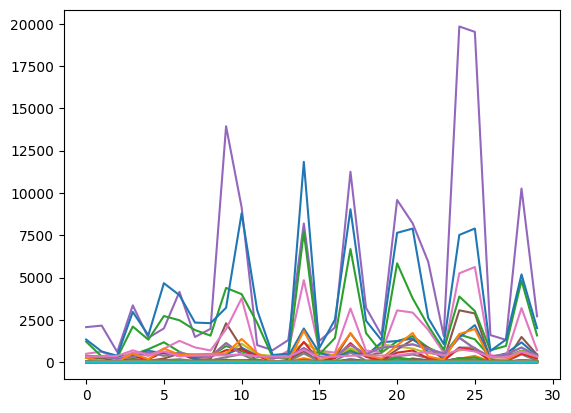

In [165]:
plt.plot(data)

In [26]:
num_features = df_features.drop(['epoch','segment_id','is_seizure'], axis =1)

In [52]:
df_features.columns

Index(['epoch', 'segment_id', 'is_seizure', 'F4-C4_mean', 'F4-C4_std',
       'F4-C4_var', 'F4-C4_delta', 'F4-C4_theta', 'F4-C4_gamma', 'F3-C3_mean',
       'F3-C3_std', 'F3-C3_var', 'F3-C3_delta', 'F3-C3_theta', 'F3-C3_gamma',
       'FT9-FT10_mean', 'FT9-FT10_std', 'FT9-FT10_var', 'FT9-FT10_delta',
       'FT9-FT10_theta', 'FT9-FT10_gamma', 'FZ-CZ_mean', 'FZ-CZ_std',
       'FZ-CZ_var', 'FZ-CZ_delta', 'FZ-CZ_theta', 'FZ-CZ_gamma', 'F7-T7_mean',
       'F7-T7_std', 'F7-T7_var', 'F7-T7_delta', 'F7-T7_theta', 'F7-T7_gamma',
       'FP2-F4_mean', 'FP2-F4_std', 'FP2-F4_var', 'FP2-F4_delta',
       'FP2-F4_theta', 'FP2-F4_gamma', 'T8-P8-1_mean', 'T8-P8-1_std',
       'T8-P8-1_var', 'T8-P8-1_delta', 'T8-P8-1_theta', 'T8-P8-1_gamma',
       'T8-P8-0_mean', 'T8-P8-0_std', 'T8-P8-0_var', 'T8-P8-0_delta',
       'T8-P8-0_theta', 'T8-P8-0_gamma', 'FP1-F3_mean', 'FP1-F3_std',
       'FP1-F3_var', 'FP1-F3_delta', 'FP1-F3_theta', 'FP1-F3_gamma',
       'CZ-PZ_mean', 'CZ-PZ_std', 'CZ-PZ_var', 'CZ-PZ

In [13]:
from source.data_import import save_pyarrow

save_pyarrow(df_features, file_name="feature_extracted")

/Users/anabroggini/Documents/bootcamp/ai2/source/../data/feature_extracted.arrow was successfully written.
